# Exercício 03

**Instruções gerais:** Sua submissão <u>deve</u> conter: 
1. Um "ipynb" com seu código e as soluções dos problemas
2. Uma versão pdf do ipynb

Caso você opte por resolver as questões de "papel e caneta" em um editor de $\LaTeX$ externo, o inclua no final da versão pdf do 'ipynb'--- submetendo um <u>único pdf</u>.

## Redução de dimensionalidade

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
import seaborn as sns
import io
import base64

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import tqdm 

import time

**1.** Considere o conjunto de dados disponível em penguins.csv, organizado em 5
colunas, sendo 4 colunas de atributos e a última a classe do padrão. Os dados
referem-se a medições anatômicas de pinguins da Antártida, classificados nas
espécies Adelie, Chinstrap e Gentoo. Maiores detalhes sobre os dados podem
ser achados em https://allisonhorst.github.io/palmerpenguins/.

**a)** Apresente a projeção em 2 dimensões dos padrões acima obtida pelo método PCA (análise dos componentes principais).

**b)** Ainda considerando o item anterior, calcule e mostre a variância explicada obtida quando a dimensão projetada é modificada (1,2,3 ou 4).

Normalize os dados antes de executar PCA. Implemente sua própria versão de PCA, mas verifique a corretude comparando contra alguma implementação popular (e.g., da biblioteca scikitlearn).

In [2]:
# Importando o dataset:
data = torch.from_numpy(pd.read_csv("./penguins.csv", header=None).to_numpy())

Variância explicada com 2 componentes principais: 88.087%


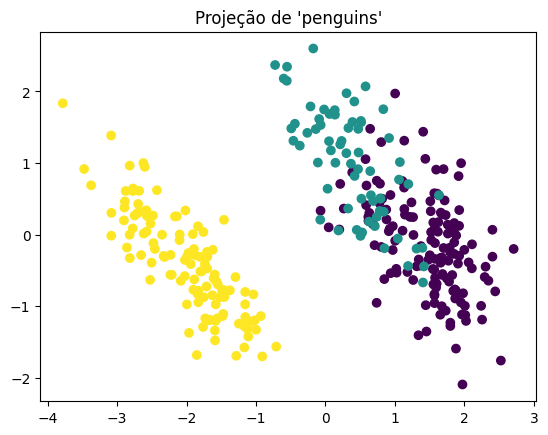

In [3]:
# Função para calcular a projeção do PCA
def my_pca(data, num_principal_components):
    # Normalizando as variáveis
    means_data = torch.mean(data, dim = 0)
    stds_data = torch.std(data, dim = 0)
    normalized_data = (data - means_data) / stds_data

    # Calculando a matriz de covariância e seus autovalores e autovetores
    cov_matrix = torch.cov(normalized_data.T)
    eigenvalues, eigenvectors = torch.linalg.eigh(cov_matrix)

    # Ordenando em função dos autovalores
    sorted_eigenvalues, sorted_indices = torch.sort(eigenvalues, descending = True)
    sorted_eigenvectors = eigenvectors[:, sorted_indices]

    # Pegando os componentes principais como os autovetores de maiores autovalores
    principal_components = sorted_eigenvectors[:, :num_principal_components]

    # Calculando a variância explicada
    explained_variation = torch.sum(sorted_eigenvalues[:num_principal_components])/torch.sum(sorted_eigenvalues)
    print(f"Variância explicada com {num_principal_components} componentes principais: {round(explained_variation.item(), 5) * 100}%")

    # Projetando os dados
    projected_data = normalized_data @ principal_components

    return projected_data

# Pegando as colunas dos padrões
patterns = data[:, :-1]

projected_data = my_pca(patterns, 2)

plt.scatter(projected_data[:, 0], projected_data[:, 1], c = data[:, -1])
plt.title("Projeção de 'penguins'")
plt.show()

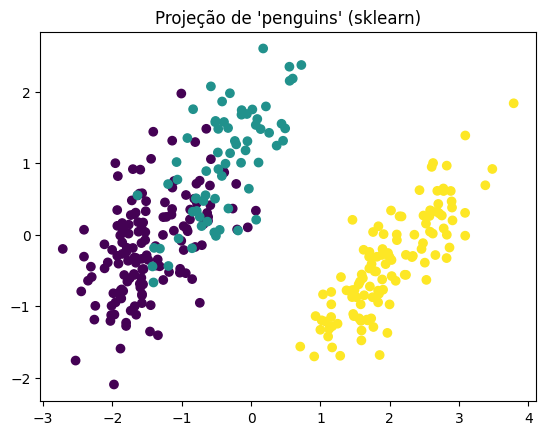

In [4]:
# Comparando com a implementação do sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
normalized_patterns = scaler.fit_transform(patterns)
pca = PCA(n_components = 2)
projected_data = pca.fit_transform(normalized_patterns)

plt.scatter(projected_data[:, 0], projected_data[:, 1], c = data[:, -1])
plt.title("Projeção de 'penguins' (sklearn)")
plt.show()

In [5]:
# Verificando a variância explicada para cada quantidade de componentes principais
for num_principal_components in range(1, 5):
    my_pca(patterns, num_principal_components)

Variância explicada com 1 componentes principais: 68.634%
Variância explicada com 2 componentes principais: 88.087%
Variância explicada com 3 componentes principais: 97.303%
Variância explicada com 4 componentes principais: 100.0%


**2.** Implemente um autoencoder determinísitco para o banco de dados MNIST, que já usamos em exercícios anteriores. Você pode escolher utilizar tanto CNN como MLP no encoder/decoder. No entanto, o encoder deve mapear as imagens no $\mathbb{R}^2$, para podermos visualizar as representações latentes no plano. Use o conjunto de validação para fazer early stopping. Você também pode monitorar o erro na validação para anelar a taxa de aprendizado (usando um scheduler). Finalmente, mostre a projeção das imagens de teste no espaço latente e comente qualitativamente os embeddings obtidos.

In [6]:
train_val_dataset = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transforms.ToTensor(),
)

test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transforms.ToTensor(),
)

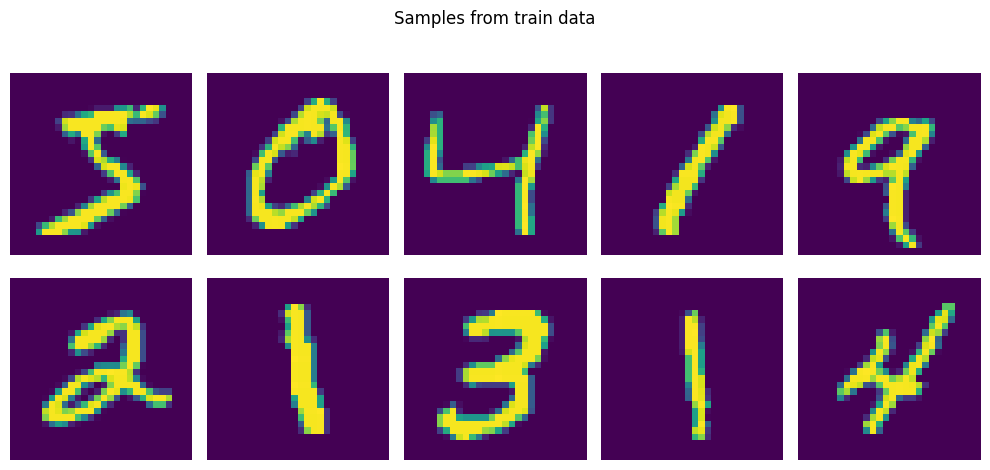

In [7]:
fig, ax = plt.subplots(2,5, figsize=(10,5))

for i in range(10):
    ax[i//5,i%5].imshow(train_val_dataset.data[i])
    ax[i//5,i%5].axis('off')
    
fig.suptitle("Samples from train data")
fig.tight_layout()

In [8]:
import torch.optim as optim
import os

# Parâmetros
input_dim = 28 * 28
latent_dim = 2
batch_size = 128
epochs = 50
learning_rate = 0.001
# Paciência para o early stopping
patience = 7
# Fator para o scheduler
factor = 0.5

# Dividindo os dados em treino e validação
train_size = int(0.8 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Criando as redes encoder e decoder
encoder = nn.Sequential(nn.Linear(input_dim, 256),
                        nn.ReLU(),
                        nn.Linear(256, 128),
                        nn.ReLU(),
                        nn.Linear(128, latent_dim)).to(device)

decoder = nn.Sequential(nn.Linear(latent_dim, 128),
                        nn.ReLU(),
                        nn.Linear(128, 256),
                        nn.ReLU(),
                        nn.Linear(256, input_dim),
                        nn.Sigmoid()).to(device)

# Otimizador
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr = learning_rate)
# MSE para a reconstrução das imagens
criterion = nn.MSELoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode = "min", 
                                                 factor = factor, 
                                                 patience = patience)

if not os.path.exists("best_autoencoder.pth"):
    # Treinando o modelo
    best_val_loss = float("inf")
    epochs_without_improve = 0

    print(f"Treinando o autoencoder com {device}")
    # Em cada época...
    for epoch in range(epochs):
        encoder.train()
        decoder.train()
        train_loss = 0

        for batch_index, (data, _) in enumerate(train_loader):
            data = data.to(device)
            # Pega a imagem para o encoder
            data_flat = data.view(data.size(0), -1)
            optimizer.zero_grad()
            # Forward pass
            latent_coords = encoder(data_flat)
            recon_batch = decoder(latent_coords)
            # Redimensiona a reconstrução para o formato original
            recon_batch_resized = recon_batch.view(data.size(0), 1, 28, 28)
            loss = criterion(recon_batch_resized, data)
            # Backward pass e otimização
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        average_train_loss = train_loss / len(train_loader)

        # Validação
        encoder.eval()
        decoder.eval()
        val_loss = 0

        with torch.no_grad():
            for data, _ in val_loader:
                data = data.to(device)
                # Pega a imagem para o encoder
                data_flat = data.view(data.size(0), -1)
                # Forward pass
                latent_coords = encoder(data_flat)
                recon_batch = decoder(latent_coords)
                # Redimensiona a reconstrução para o formato original
                recon_batch_resized = recon_batch.view(data.size(0), 1, 28, 28)
                loss = criterion(recon_batch_resized, data)
                val_loss += loss.item()

        average_val_loss = val_loss / len(val_loader)

        print(f'Época [{epoch + 1}/{epochs}], Erro de treino: {average_train_loss:.4f}, Erro de validação: {average_val_loss:.4f}')

        # Scheduler
        scheduler.step(average_val_loss)

        # Early stopping
        if average_val_loss < best_val_loss:
            best_val_loss = average_val_loss
            epochs_without_improve = 0
            torch.save({"encoder_state_dict": encoder.state_dict(),
                        "decoder_state_dict": decoder.state_dict()}, "best_autoencoder.pth")
        else:
            epochs_without_improve += 1
            if epochs_without_improve == patience:
                print(f"Early stopping na época {epoch + 1}")
                break

    print("Treinamento concluído")

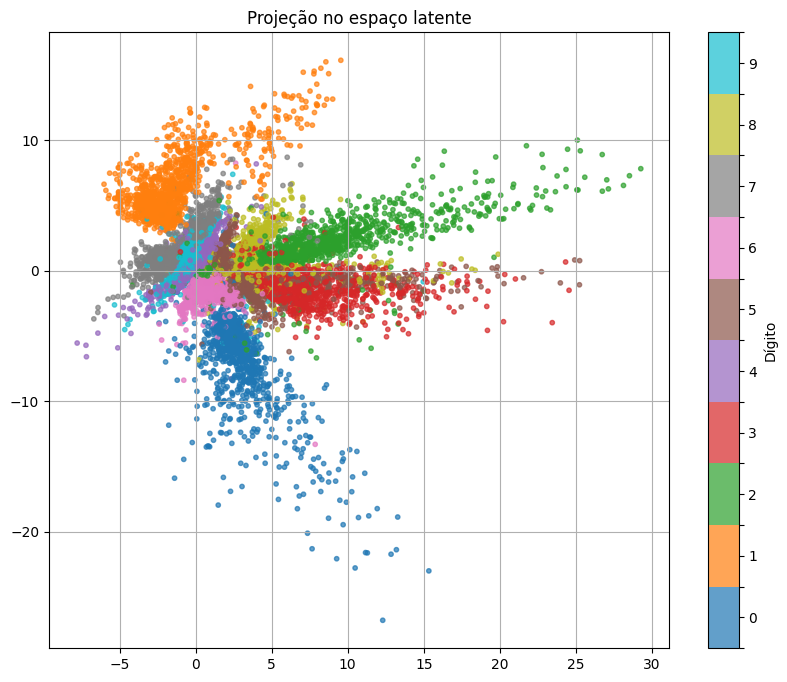

In [9]:
# Carregando o melhor modelo
checkpoint = torch.load("best_autoencoder.pth")
encoder.load_state_dict(checkpoint["encoder_state_dict"])
decoder.load_state_dict(checkpoint["decoder_state_dict"])
encoder.eval()
decoder.eval()

# Projetando as imagens de teste no espaço latente
all_latent_coords = []
all_labels = []

with torch.no_grad():
    for data, labels in test_loader:
        data = data.to(device)
        # Pega a imagem para o encoder
        data_flat = data.view(data.size(0), -1)
        # Forward pass
        latent_coords = encoder(data_flat)
        all_latent_coords.append(latent_coords.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_latent_coords = np.concatenate(all_latent_coords, axis = 0)
all_labels = np.concatenate(all_labels, axis = 0)

# Visualizando as representações latentes
plt.figure(figsize = (10, 8))
plt.scatter(all_latent_coords[:, 0], all_latent_coords[:, 1], c = all_labels, cmap = "tab10", s = 10, alpha = 0.7)
tick_values = np.arange(0, 10, 0.45)
tick_labels = [str(round(t)) if not np.isclose(t / 0.9, int(t / 0.9)) else "" for t in tick_values]
cbar = plt.colorbar(ticks = tick_values, label = "Dígito")
cbar.set_ticklabels(tick_labels)
plt.title("Projeção no espaço latente")
plt.grid(True)
plt.show()

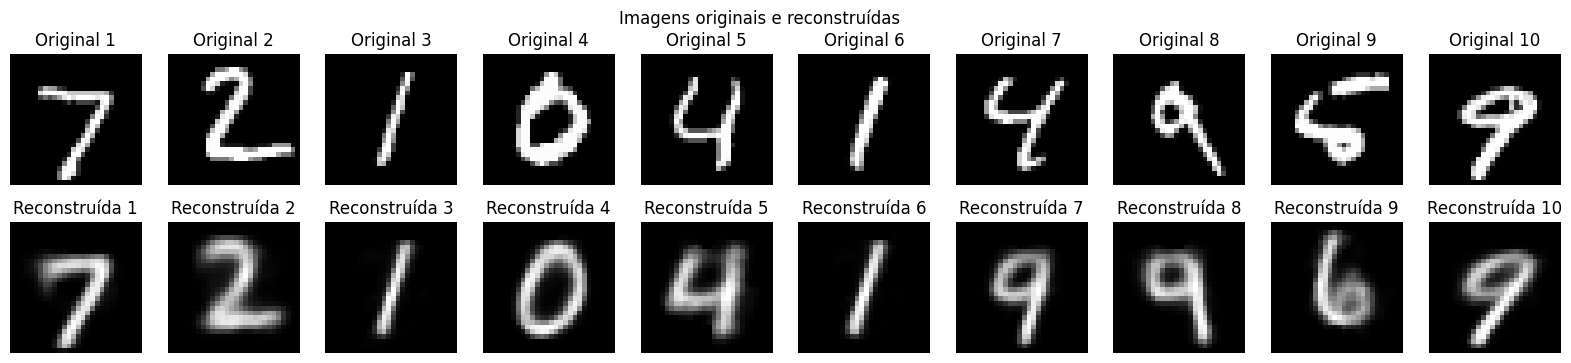

In [10]:
# Visualizando algumas reconstruções
num_images = 10

encoder.eval()
decoder.eval()

with torch.no_grad():
    data, _ = next(iter(test_loader))
    data = data[:num_images].to(device)
    # Pega a imagem para o encoder
    data_flat = data.view(data.size(0), -1)
    # Forward pass
    latent_coords = encoder(data_flat)
    recon_batch = decoder(latent_coords)
    # Redimensiona a reconstrução para o formato original
    recon_batch_resized = recon_batch.view(data.size(0), 1, 28, 28)
    
    fig, axes = plt.subplots(2, num_images, figsize = (num_images * 2, 4))

    for i in range(num_images):
        # Plotando a imagem original
        axes[0, i].imshow(data[i].cpu().squeeze().numpy(), cmap = "gray")
        axes[0, i].set_title(f"Original {i + 1}")
        axes[0, i].axis("off")

        # Plotando a reconstrução
        axes[1, i].imshow(recon_batch_resized[i].cpu().squeeze().numpy(), cmap = "gray")
        axes[1, i].set_title(f"Reconstruída {i + 1}")
        axes[1, i].axis("off")

    plt.suptitle("Imagens originais e reconstruídas")
    plt.show()

**Resposta**: Com base na projeção no espaço latente exibida acima, nota-se que há uma tendência de formação de clusters para os dígitos, com pontos da mesma classe se agrupando em regiões próximas e com grupos de dígitos diferentes ficando relativamente separados entre si. Isso mostra que o autoencoder obteve sucesso em sua tarefa de manter as características dos dados mesmo em uma dimensão muito menor que a original.

Além disso, é possível observar que, mesmo dentro de um cluster, há certas dispersões, o que reflete a variância natural das imagens de um mesmo dígito causada pelos diferentes estilos de escrita. Assim, temos que o autoencoder tenta aprender essa variância e representá-la no espaço latente.

Por fim, observando as imagens reconstruídas exibidas acima, é notável a alta qualidade da reconstrução feita pelo modelo, o que mostra que ele conseguiu preservar as características essenciais das imagens originais, aprendendo um espaço latente com apenas 2 dimensões que é muito informativo.

## K-means e Mixture models

## Exercícios práticos

In [11]:
mnist_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, 
                                            transform=torchvision.transforms.ToTensor())
fashion_mnist_trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, 
                                                           transform=torchvision.transforms.ToTensor()) 

mnist_testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, 
                                            transform=torchvision.transforms.ToTensor())

In [12]:
def display_nine_images(dataset):
    for i, (image, label) in enumerate(dataset): 
        plt.subplot(3, 3, i + 1) 
        plt.imshow(image.permute(1, 2, 0), cmap='gray')
        plt.axis('off')
        plt.title(f'Label: {label}') 
        if i >= 8: break 
    plt.suptitle(dataset.__class__.__name__) 
    plt.tight_layout()  

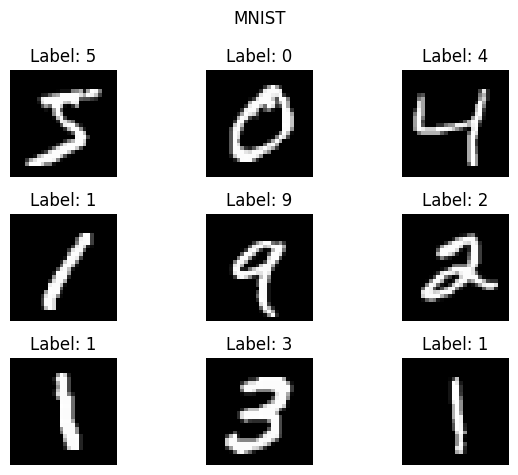

In [13]:
display_nine_images(mnist_trainset)

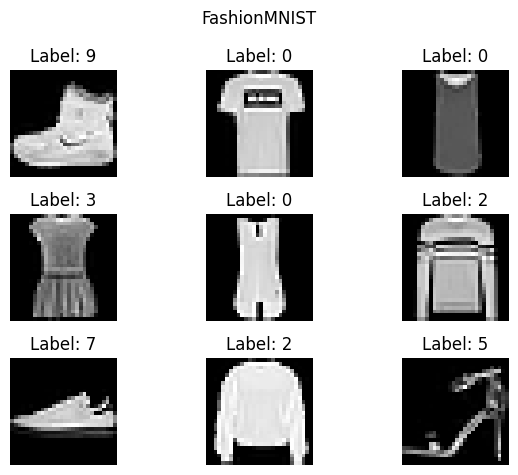

In [14]:
display_nine_images(fashion_mnist_trainset)

**1.** Implemente o algoritmo de $K$-means e aplique-o ao MNIST usando $K=10$ (o número de dígitos no banco de dados) --- inicializando os centroides aleatoriamente ou usando a estratégia do k-means++. Considere também inicializar os centróides como as médias das imagens de cada classe (é possível já que MNIST possui labels). Em geral, imagens similares são agrupadas junto? Plote exemplos de amostras em cada cluster.

In [15]:
# Função do k-means
def k_means(data, k, max_iters = 100, initialization = "random", true_labels = None):
    N, D = data.shape
    centroids = np.zeros((k, D))

    # Inicializando os centróides
    if initialization == "random":
        random_indices = np.random.choice(N, k, replace = False)
        centroids = data[random_indices]
    elif initialization == "mean_labels":
        for i in range(k):
            class_data = data[true_labels == i]
            centroids[i] = np.mean(class_data, axis = 0)
    else:
        print("Inicialização inválida. Escolha 'random' or 'mean_labels'")

    # Em cada iteração...
    for i in tqdm.tqdm(range(max_iters), desc = "Iterações", unit = "iteração"):
        
        # Calcula as distâncias de todos os pontos a todos os centróides
        distances = np.sqrt(np.sum((data[:, np.newaxis, :] - centroids)**2, axis = 2))
        # Atribui cada ponto ao centróide mais próximo
        cluster_assignments = np.argmin(distances, axis = 1)

        # Recalcula os centróides
        new_centroids = np.zeros((k, D))
        for cluster in range(k):
            points_in_cluster = data[cluster_assignments == cluster]
            new_centroids[cluster] = np.mean(points_in_cluster, axis = 0)

        # Verifica a convergência
        if np.allclose(centroids, new_centroids):
            print(f"K-means convergido na iteração {i + 1}")
            return new_centroids, cluster_assignments
        
        centroids = new_centroids

    return centroids, cluster_assignments

In [16]:
import json

data_flat = mnist_trainset.data.float().view(len(mnist_trainset), -1).numpy() / 255.0
labels = mnist_trainset.targets.numpy()

# Executando com inicialização aleatória
if not os.path.exists("random_kmeans.json"):
    random_centroids, random_clusters = k_means(data_flat, 10)
    results = {"centroids": random_centroids.tolist(),
               "clusters": random_clusters.tolist()}
    with open("random_kmeans.json", "w") as f:
        json.dump(results, f, indent = 4)

# Executando com inicialização na média dos labels
if not os.path.exists("mean_labels_kmeans.json"):
    mean_labels_centroids, mean_labels_clusters = k_means(data_flat, 10, 1,
                                                          initialization = "mean_labels", 
                                                          true_labels = labels)
    results = {"centroids": mean_labels_centroids.tolist(),
               "clusters": mean_labels_clusters.tolist()}
    with open("mean_labels_kmeans.json", "w") as f:
        json.dump(results, f, indent = 4)

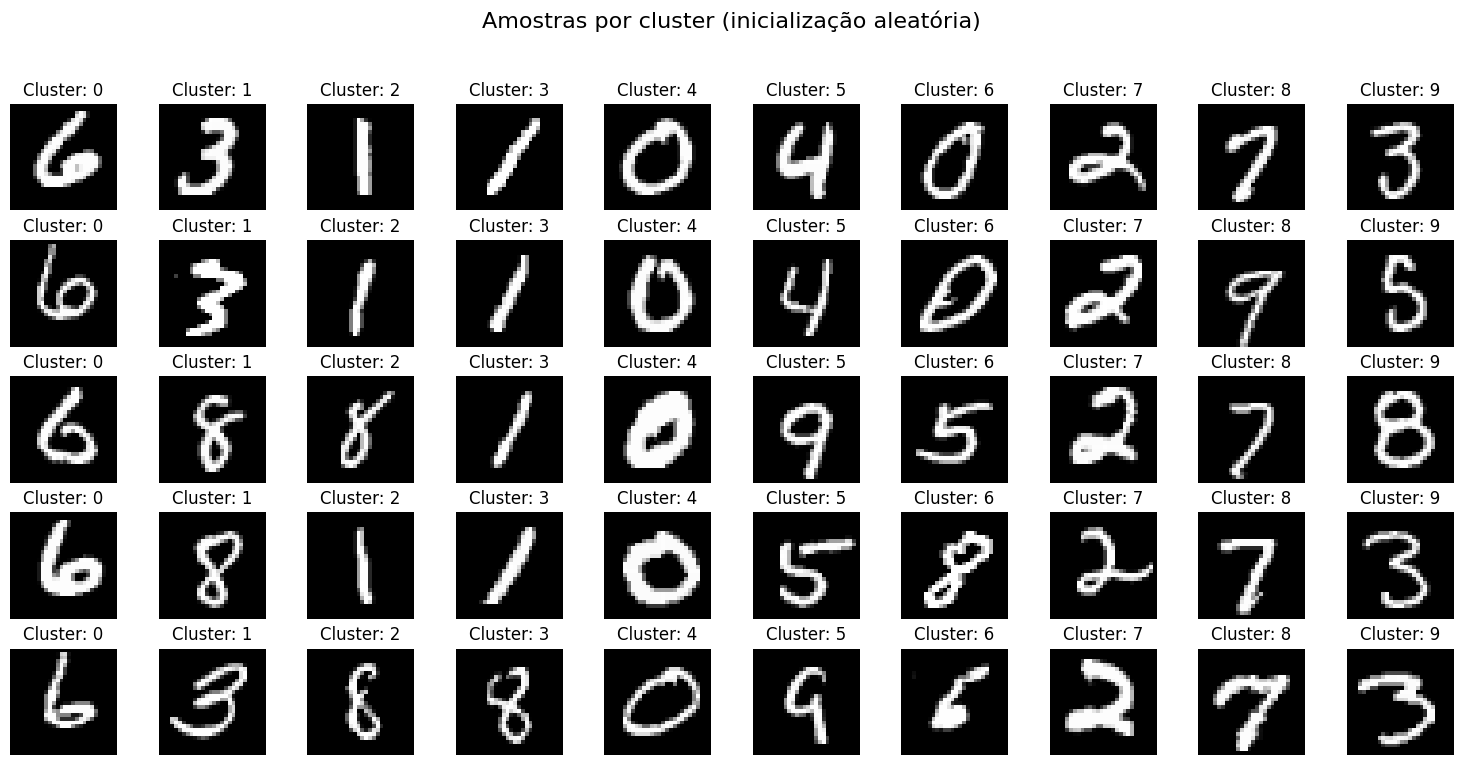

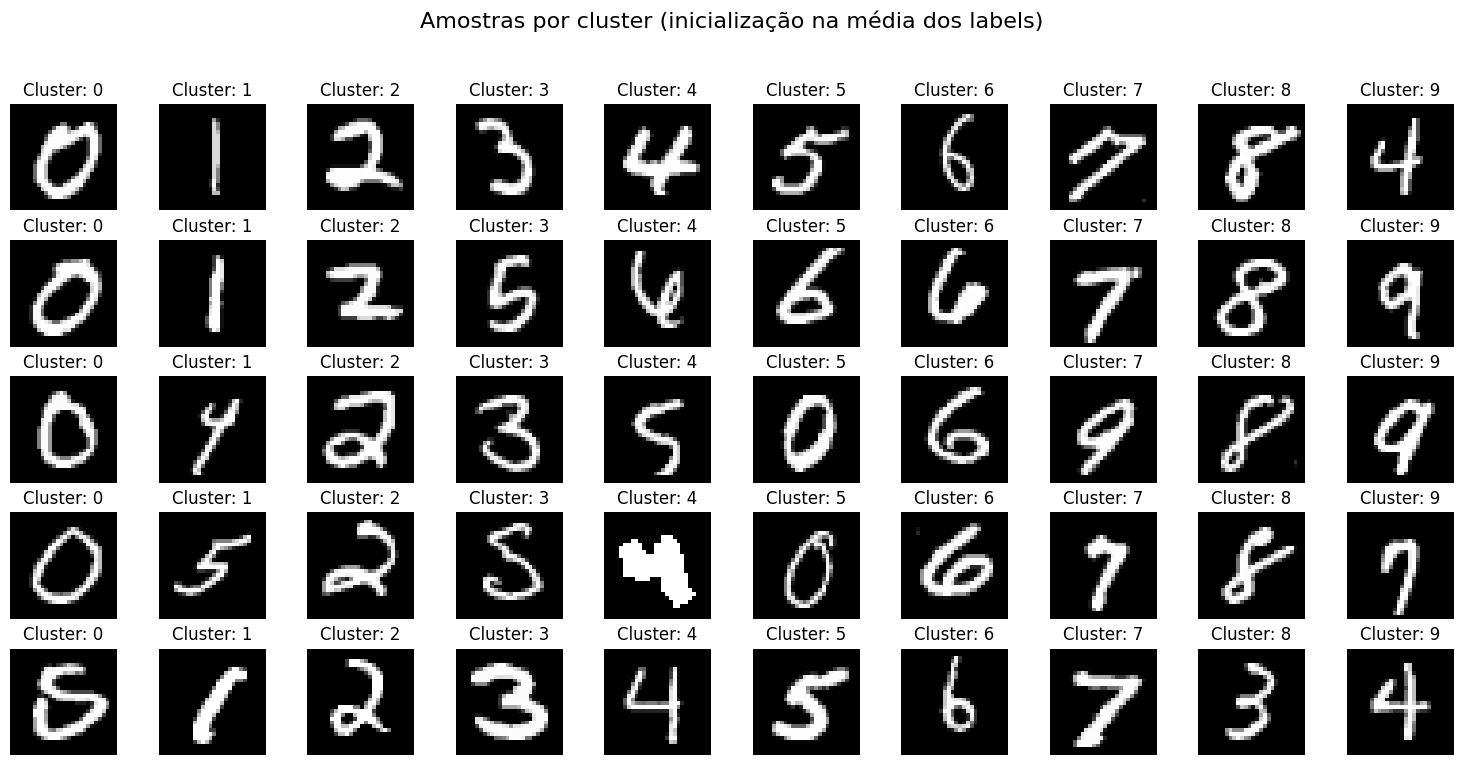

In [19]:
import random

# Função para plotar exemplos de imagens de cada cluster
def plot_examples(data, k, clusters, initialization):
    plt.figure(figsize = (15, 8))
    plt.suptitle(f"Amostras por cluster ({initialization})", fontsize = 16)
    # Para cada cluster...
    for cluster in range(k):
        # Pega as amostras nesse cluster
        cluster_samples_indices = np.where(clusters == cluster)[0]
        # Pega 5 dessas amostras
        selected_sample_indices = random.sample(list(cluster_samples_indices), 5)
        # Plota essas amostras
        for i, sample_index in enumerate(selected_sample_indices):
            ax = plt.subplot(5, k, cluster + 10 * i + 1)
            ax.imshow(data[sample_index].reshape(28, 28), cmap = "gray")
            ax.set_title(f"Cluster: {cluster}", fontsize = 12)
            ax.axis("off")

    plt.tight_layout(rect = [0, 0.03, 1, 0.95])
    plt.show()

with open("random_kmeans.json", "r") as f:
    data = json.load(f)
    random_clusters = np.array(data["clusters"])

with open("mean_labels_kmeans.json", "r") as f:
    data = json.load(f)
    mean_labels_clusters = np.array(data["clusters"])

plot_examples(data_flat, 10, random_clusters, "inicialização aleatória")
plot_examples(data_flat, 10, mean_labels_clusters, "inicialização na média dos labels")

**Resposta**: Como pode ser observado pelas imagens acima, em geral, sim, imagens similares tendem a ser agrupadas juntas. No entanto, isso pode levar a classificações incorretas quando há digítos muito semelhantes, seja pelas características inerentes aos próprios algarismos, seja pela grafia da amostra. Isso pode ser facilmente visto por meio das confusões que ocorrem principalmente entre os dígitos 4 e 9 e entre os dígitos 3 e 8.

**2.** Gaussian Mixture Models (GMMs) são estimadores de densidade poderosos. Podemos utilizá-los, por exemplo, para detectar amostras "fora da distribuição de treino" (out-of-distribution, OOD) em tempo de teste, evitando possíveis previsões catastróficias. Com isso em mente: 
- (a) treine um MLP para classificar o MNIST;
- (b) com o MLP treinado, use um GMM para modelar as ativações da penúltima camada desse MLP (usando as ativações dos dados de treino);
- (c) avalie a capacidade dessa GMM em diferenciar amostras de teste do MNIST e do FashionMNIST (espera-se que amostras OOD --- do FashionMNIST--- estejam nas caudas);
- (d) teste essa estratégia com números diferentes de componente das misturas e escolha a que provê a melhor separação. 

Para simplificar sua vida, use a implementação de GMM do scikit-learn.

In [64]:
# Parâmetros
input_dim = 28 * 28
# Dimensão da penúltima camada do MLP
hidden_dim = 256
output_dim = 10
batch_size = 128
mlp_epochs = 10
mlp_lr = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Pegando o conjunto de teste do Fashion MNIST que é menor e mais coerente com o de teste do MNIST
# que será usado para diferenciar pontos de dentro e de fora da amostra
fashion_mnist_testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, 
                                                          transform=torchvision.transforms.ToTensor())

# Carregando os dados
mnist_train_loader = DataLoader(mnist_trainset, batch_size = batch_size, shuffle = True)
mnist_test_loader = DataLoader(mnist_testset, batch_size = batch_size, shuffle = False)
fashion_mnist_test_loader = DataLoader(fashion_mnist_testset, batch_size = batch_size, shuffle = False)

# (a) Treinando o modelo MLP para classificar o MNIST

# Definindo o MLP
mlp_model = nn.Sequential(nn.Flatten(),
                          nn.Linear(input_dim, 512),
                          nn.ReLU(),
                          # Camada que será usada para o GMM
                          nn.Linear(512, hidden_dim),
                          nn.ReLU(),
                          nn.Linear(hidden_dim, output_dim)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model.parameters(), lr = mlp_lr)

if not os.path.exists("mlp_mnist.pth"):
    for epoch in range(mlp_epochs):
        mlp_model.train()
        running_loss = 0

        for images, labels in mnist_train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass
            x = images.view(images.size(0), -1)
            outputs = mlp_model(x)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f'Época [{epoch + 1}/{mlp_epochs}], Erro de treino: {running_loss/len(mnist_train_loader):.4f}')

    torch.save(mlp_model.state_dict(), "mlp_mnist.pth")

# Carregando o modelo
mlp_model.load_state_dict(torch.load("mlp_mnist.pth"))

# Avaliando a precisão do MLP
mlp_model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in mnist_test_loader:
        images, labels = images.to(device), labels.to(device)
        # Forward pass
        outputs = mlp_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Precisão do MLP no conjunto de teste: {correct / total:.2f}")

Precisão do MLP no conjunto de teste: 0.98


In [65]:
# (b) Modelando as ativações da penúltima camada com um GMM
# (c) Avaliando a capacidade do GMM de diferenciar dados de dentro e de fora da amostra

from sklearn.mixture import GaussianMixture
from sklearn.metrics import roc_auc_score

# Função para extrair as features de um conjunto de dados
def extract_features(model, dataloader):
    model.eval()
    features_list = []

    with torch.no_grad():
        # Para cada dado do conjunto de dados...
        for images, _ in dataloader:
            images = images.to(device)
            x = images.view(images.size(0), -1)

            # Passa pelas camadas para pegar as features da penúltima camada
            features = model[1](x)
            features = model[2](features)
            features = model[3](features)
            features = model[4](features)

            features_list.append(features.cpu().numpy())

    return np.concatenate(features_list, axis = 0)

# Extraindo as features dos conjuntos de treino e teste e do FashionMNIST
mnist_train_features = extract_features(mlp_model, mnist_train_loader)
mnist_test_features = extract_features(mlp_model, mnist_test_loader)
fashion_mnist_test_features = extract_features(mlp_model, fashion_mnist_test_loader)

# Rótulos verdadeiros da predição de OOD
true_ood_labels = np.concatenate([np.zeros(len(mnist_test_features)), np.ones(len(fashion_mnist_test_features))])

# Função para ajustar um GMM às features dos dados de treino
def fit_and_evaluate_gmm(n_comp):
    gmm = GaussianMixture(n_components = n_comp, random_state = 42, verbose = 0, n_init = 3)
    gmm.fit(mnist_train_features)
    
    # Calculando os scores para os dois conjuntos de avaliação
    log_probs_mnist = gmm.score_samples(mnist_test_features)
    log_probs_fashion_mnist = gmm.score_samples(fashion_mnist_test_features)

    all_log_probs = np.concatenate([log_probs_mnist, log_probs_fashion_mnist])
    # Invertendo para que os pontos OOD tenham valores maiores
    ood_scores = -all_log_probs

    # Calcula a ROC para avaliar
    roc_auc = roc_auc_score(true_ood_labels, ood_scores)

    return gmm, roc_auc

In [109]:
# (d) Testando com diferentes números de componentes

import joblib

n_components_options = [5, 10, 20]
best_n_components = -1
# Usando a AUC ROC para avaliar
best_roc_auc = -1
best_gmm = None

if not os.path.exists("best_gmm_model.joblib"):
    for n_comp in n_components_options:
        print(f"Testando com {n_comp} componentes")
        current_gmm, current_roc_auc = fit_and_evaluate_gmm(n_comp)
        if current_roc_auc > best_roc_auc:
            best_n_components = n_comp
            best_roc_auc = current_roc_auc
            best_gmm = current_gmm

    print(f"Melhor número de componentes: {best_n_components}; AUC ROC: {best_roc_auc}")
    # Salvando o modelo
    joblib.dump(best_gmm, "best_gmm_model.joblib")

best_gmm = joblib.load("best_gmm_model.joblib")

print(f"Melhor número de componentes: {best_gmm.n_components}")

Melhor número de componentes: 20


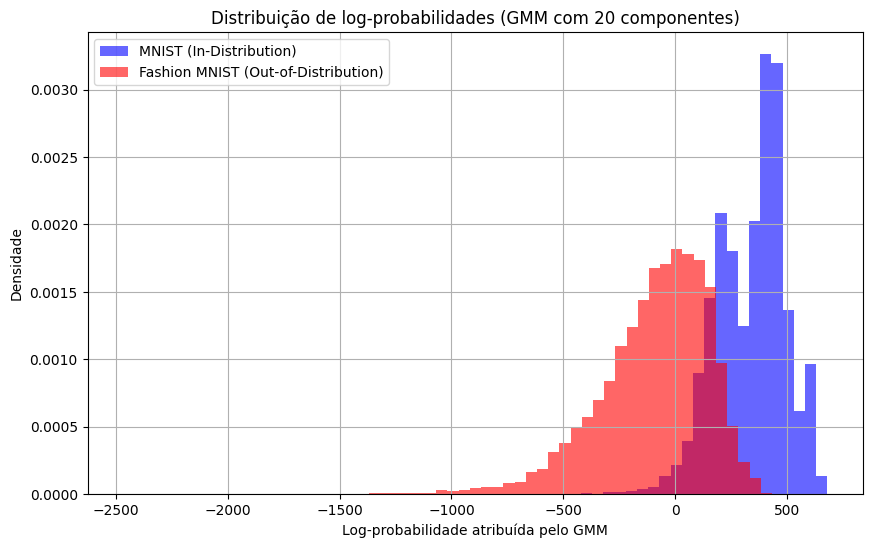

In [ ]:
# Plotando as distribuições dos scores dos dados de dentro e de fora da amostra
best_log_probs_mnist = best_gmm.score_samples(mnist_test_features)
best_log_probs_fashion_mnist = best_gmm.score_samples(fashion_mnist_test_features)

bins_edges_mnist = np.arange(np.min(best_log_probs_mnist), np.max(best_log_probs_mnist) + 50, 50)
bins_edges_fashion_mnist = np.arange(np.min(best_log_probs_fashion_mnist), np.max(best_log_probs_fashion_mnist) + 50, 50)

plt.figure(figsize = (10, 6))
plt.hist(best_log_probs_mnist, bins = bins_edges_mnist, density = True, alpha = 0.6, label = "MNIST (In-Distribution)", color = "blue")
plt.hist(best_log_probs_fashion_mnist, bins = bins_edges_fashion_mnist, density = True, alpha = 0.6, label = "Fashion MNIST (Out-of-Distribution)", color = "red")
plt.title(f"Distribuição de log-probabilidades (GMM com {best_gmm.n_components} componentes)")
plt.xlabel("Log-probabilidade atribuída pelo GMM")
plt.ylabel("Densidade")
plt.legend()
plt.grid(True)
plt.show()

## Modelos baseados em energia (EBM)

(-7.0, 7.0)

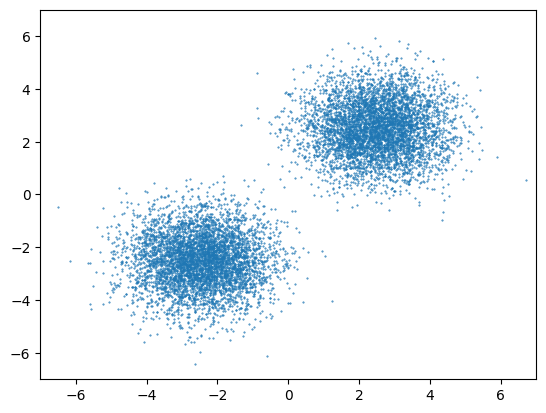

In [21]:
import torch
import torch.nn as nn
import torch_sgld
import seaborn as sns
import matplotlib.pyplot as plt

N = 10000
d = 2
data = torch.randn((int(N/2),d)) + 2.5
data2 = torch.randn((int(N/2),d)) - 2.5
data = torch.cat((data, data2), dim=0)


plt.scatter(data[:,0], data[:,1], s=0.2)
plt.xlim([-7, 7])
plt.ylim([-7, 7])

**1.** Considere as a amostras da distribuição acima, contidas na variável 'data'. Complete o código abaixo para implementar um modelo baseado em energia (EBM) que amostre aproximadamente da distribuição subjacente a esses dados. Depois de treinar o modelo, amostre do EBM e compare o resultado contra o scatterplot acima. Analise o efeito de mudar a quantidade de iterações de SGLD por época. Além disso, a implementação abaixo usa cadeias 'persistentes' entre épocas --- i.e., o estado final da última época é o inicial da atual. Qual o efeito de inicializar aleatoriamente a cadeia em cada iteração? E de inicializá-las nos pontos observados em 'data'?

In [22]:
torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

h = 10
E = nn.Sequential(nn.Linear(d, h), nn.ReLU(), nn.Linear(h, h), nn.ReLU(),nn.Linear(h, 1)).to(device)
data = data.to(device)

max_iter = 10000

x = torch.randn((N,2), device=device)*5.0
x.requires_grad=True
optimizer = torch.optim.Adam(E.parameters(), lr=0.001)
sampler = torch_sgld.SGLD([x], lr=0.1) 

chain_length=10

if not os.path.exists("energy_model.pth"):
    for _ in tqdm.tqdm(range(max_iter), desc = "Treinando EBM", unit = "iterações"):
        # Zera os gradientes da rede neural
        E.zero_grad()

        # Passo da amostragem
        for _ in range(chain_length):
            sampler.zero_grad()
            potential = E(x)
            potential.sum().backward()
            sampler.step()

        # Passo da otimização
        optimizer.zero_grad()
        # Energia das amostras reais
        positive_energy = E(data).mean()
        # Energia das amostras geradas
        negative_energy = E(x.detach()).mean()
        loss = positive_energy - negative_energy
        loss.backward()
        optimizer.step()

    torch.save(E.state_dict(), "energy_model.pth")

In [29]:
# Amostragem final do EBM
E.load_state_dict(torch.load("energy_model.pth"))

final_samples_x = torch.randn((N, d), device = device) * 5.0
final_samples_x.requires_grad = True
final_sampler = torch_sgld.SGLD([final_samples_x], lr = 0.1)

final_chain_length = 5000
for _ in tqdm.tqdm(range(final_chain_length), desc = "Amostragem final SGLD"):
    final_sampler.zero_grad()
    potential = E(final_samples_x)
    potential.sum().backward()
    final_sampler.step()

generated_data = final_samples_x.detach().cpu().numpy()

Amostragem final SGLD: 100%|██████████| 5000/5000 [00:24<00:00, 202.64it/s]


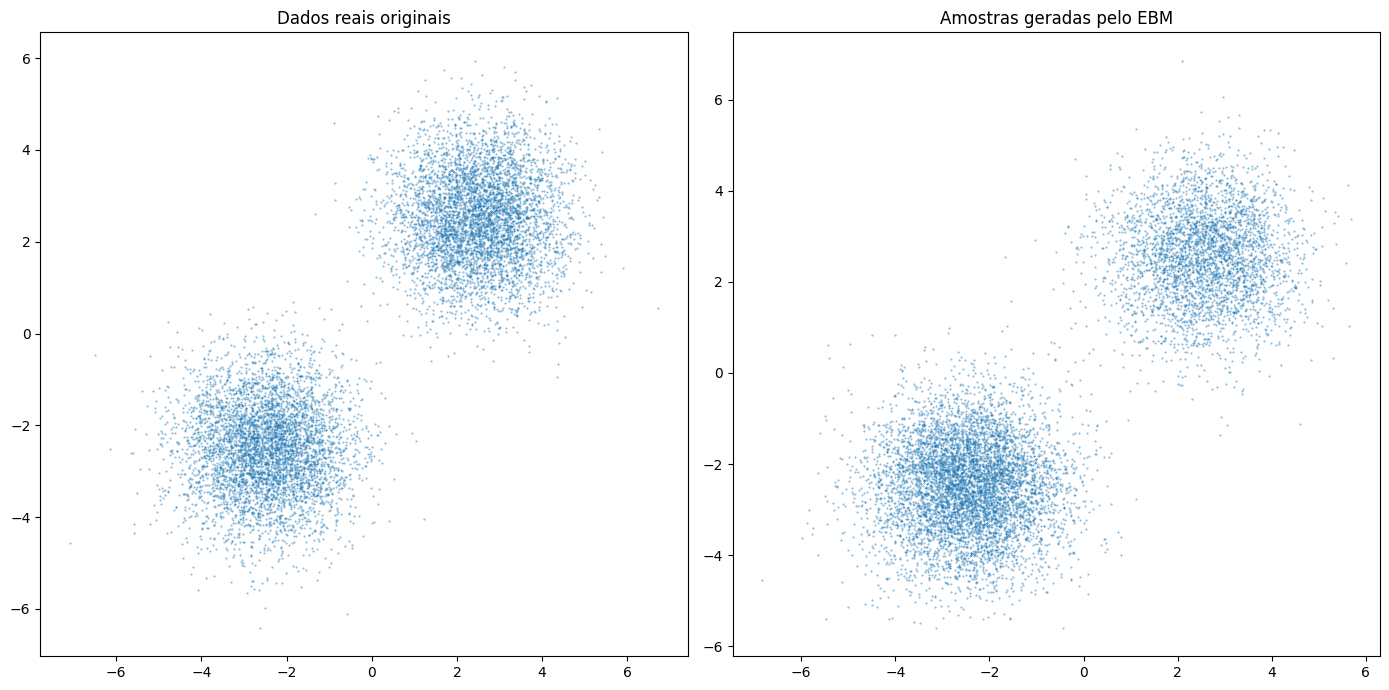

In [30]:
# Plotando os resultados
plt.figure(figsize = (14, 7))

plt.subplot(1, 2, 1)
plt.scatter(data.cpu().numpy()[:, 0], data.cpu().numpy()[:, 1], s = 0.2, alpha = 0.6)
plt.title("Dados reais originais")

plt.subplot(1, 2, 2)
plt.scatter(generated_data[:, 0], generated_data[:, 1], s = 0.2, alpha = 0.6)
plt.title("Amostras geradas pelo EBM")

plt.tight_layout()
plt.show()

In [27]:
# Função para treinar e amostrar de EBMs com diferentes quantidades de iterações de SGLD e
# com diferentes técnicas de inicialização da cadeia
def train_ebm_and_sample(data_true,
                         chain_length_per_epoch,
                         sgld_init_strategy='persistent', # "persistent", "random_per_epoch", "data_per_epoch"
                         num_final_samples=N):
    
    print(f"\n--- Treinando EBM ---")
    print(f"Estratégia de Inicialização SGLD: {sgld_init_strategy}")
    print(f"Chain Length (SGLD passos por época): {chain_length_per_epoch}")

    # Otimizador para os parâmetros da rede de energia
    E = nn.Sequential(nn.Linear(d, h), nn.ReLU(), nn.Linear(h, h), nn.ReLU(),nn.Linear(h, 1)).to(device)
    optimizer = torch.optim.Adam(E.parameters(), lr = 0.001)

    # Inicialização das amostras "x" para SGLD
    if sgld_init_strategy == "persistent":
        x = torch.randn((num_final_samples, d), device = device) * 5.0
        x.requires_grad = True
        sampler = torch_sgld.SGLD([x], lr = 0.1)
    elif sgld_init_strategy == "random_per_epoch" or sgld_init_strategy == "data_per_epoch":
        x = None 
        sampler = None 
    else:
        print("Estratégia de inicialização SGLD inválida.")

    if not os.path.exists(f"e_{sgld_init_strategy}_{chain_length_per_epoch}.pth"):
        for _ in tqdm.tqdm(range(10000), desc = f"Treinando EBM ({sgld_init_strategy}, CL = {chain_length_per_epoch})"):
            # Zera gradientes da rede de energia
            E.zero_grad()

            # Lógica de inicialização de SGLD por época
            if sgld_init_strategy == "random_per_epoch":
                x = torch.randn((num_final_samples, d), device = device) * 5.0
                x.requires_grad = True
                sampler = torch_sgld.SGLD([x], lr = 0.1)
            elif sgld_init_strategy == "data_per_epoch":
                indices = np.random.choice(len(data_true), num_final_samples, replace = True)
                x = data_true[indices].clone().detach()
                x.requires_grad = True
                sampler = torch_sgld.SGLD([x], lr = 0.1)
                
            # Passo de amostragem
            for _ in range(chain_length_per_epoch):
                sampler.zero_grad()
                potential = E(x)
                potential.sum().backward()
                sampler.step()
            
            # Passo de otimização
            optimizer.zero_grad()
            
            positive_energy = E(data_true).mean()
            negative_energy = E(x.detach()).mean() 
            
            loss = positive_energy - negative_energy 
            
            loss.backward()
            optimizer.step()

        torch.save(E.state_dict(), f"e_{sgld_init_strategy}_{chain_length_per_epoch}.pth")

    E.load_state_dict(torch.load(f"e_{sgld_init_strategy}_{chain_length_per_epoch}.pth"))

    # Amostragem final do EBM    
    final_samples_x = torch.randn((num_final_samples, d), device = device) * 5.0
    final_samples_x.requires_grad = True
    final_sampler = torch_sgld.SGLD([final_samples_x], lr = 0.1)

    for _ in tqdm.tqdm(range(5000), desc = "Amostragem Final SGLD"):
        final_sampler.zero_grad()
        potential = E(final_samples_x)
        potential.sum().backward()
        final_sampler.step()

    generated_data = final_samples_x.detach().cpu().numpy()
    return generated_data


--- Treinando EBM ---
Estratégia de Inicialização SGLD: persistent
Chain Length (SGLD passos por época): 5


Amostragem Final SGLD: 100%|██████████| 5000/5000 [00:18<00:00, 274.56it/s]



--- Treinando EBM ---
Estratégia de Inicialização SGLD: persistent
Chain Length (SGLD passos por época): 50


Amostragem Final SGLD: 100%|██████████| 5000/5000 [00:13<00:00, 381.34it/s]


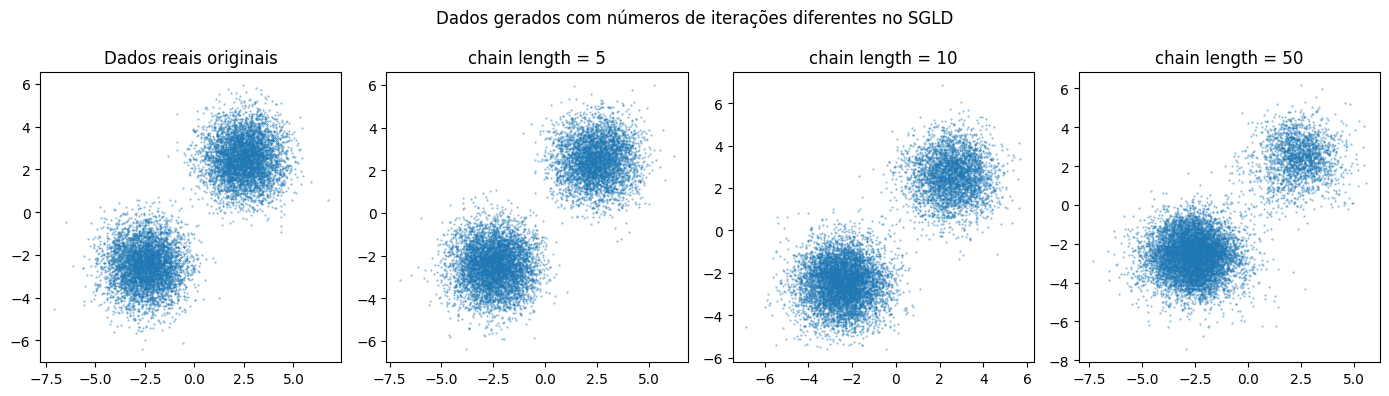

In [34]:
# Plotando os resultados para números de iterações no SGLD diferentes
generated_data_5 = train_ebm_and_sample(data, 5)
generated_data_50 = train_ebm_and_sample(data, 50)

plt.figure(figsize = (14, 4))

plt.subplot(1, 4, 1)
plt.scatter(data.cpu().numpy()[:, 0], data.cpu().numpy()[:, 1], s = 0.2, alpha = 0.6)
plt.title("Dados reais originais")

plt.subplot(1, 4, 2)
plt.scatter(generated_data_5[:, 0], generated_data_5[:, 1], s = 0.2, alpha = 0.6)
plt.title("chain length = 5")

plt.subplot(1, 4, 3)
plt.scatter(generated_data[:, 0], generated_data[:, 1], s = 0.2, alpha = 0.6)
plt.title("chain length = 10")

plt.subplot(1, 4, 4)
plt.scatter(generated_data_50[:, 0], generated_data_50[:, 1], s = 0.2, alpha = 0.6)
plt.title("chain length = 50")

plt.suptitle("Dados gerados com números de iterações diferentes no SGLD")
plt.tight_layout()
plt.show()


--- Treinando EBM ---
Estratégia de Inicialização SGLD: random_per_epoch
Chain Length (SGLD passos por época): 10


Amostragem Final SGLD: 100%|██████████| 5000/5000 [00:22<00:00, 218.17it/s]



--- Treinando EBM ---
Estratégia de Inicialização SGLD: data_per_epoch
Chain Length (SGLD passos por época): 10


Amostragem Final SGLD: 100%|██████████| 5000/5000 [00:42<00:00, 118.19it/s]


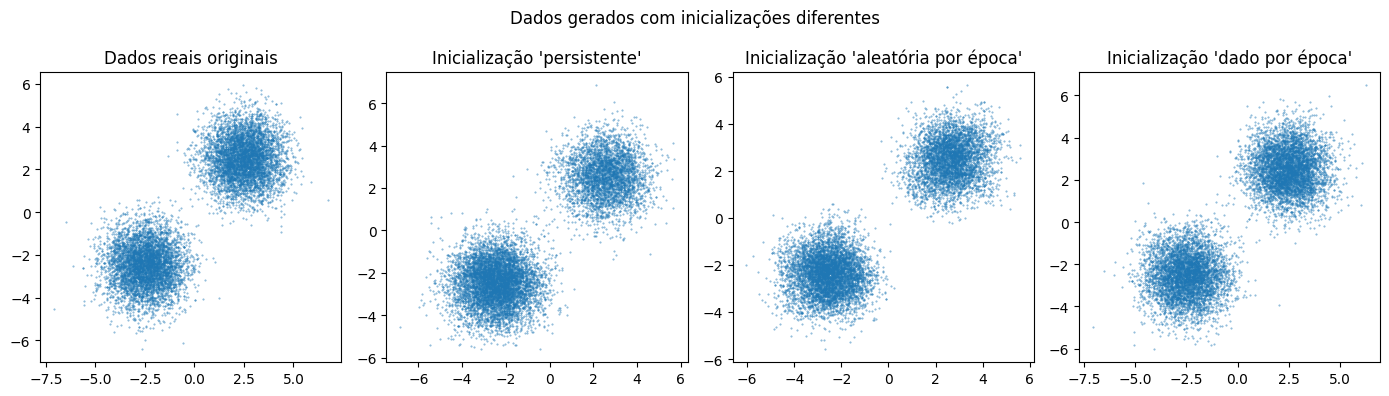

In [31]:
# Plotando os resultados para diferentes inicializações
generated_data_random_per_epoch = train_ebm_and_sample(data, 10, sgld_init_strategy = "random_per_epoch")
generated_data_data_per_epoch = train_ebm_and_sample(data, 10, sgld_init_strategy = "data_per_epoch")

plt.figure(figsize = (14, 4))

plt.subplot(1, 4, 1)
plt.scatter(data.cpu().numpy()[:, 0], data.cpu().numpy()[:, 1], s = 0.2, alpha = 0.6)
plt.title("Dados reais originais")

plt.subplot(1, 4, 2)
plt.scatter(generated_data[:, 0], generated_data[:, 1], s = 0.2, alpha = 0.6)
plt.title("Inicialização 'persistente'")

plt.subplot(1, 4, 3)
plt.scatter(generated_data_random_per_epoch[:, 0], generated_data_random_per_epoch[:, 1], s = 0.2, alpha = 0.6)
plt.title("Inicialização 'aleatória por época'")

plt.subplot(1, 4, 4)
plt.scatter(generated_data_data_per_epoch[:, 0], generated_data_data_per_epoch[:, 1], s = 0.2, alpha = 0.6)
plt.title("Inicialização 'dado por época'")

plt.suptitle("Dados gerados com inicializações diferentes")
plt.tight_layout()
plt.show()

**Resposta**: Para um comprimento de cadeia muito curto (de tamanho 5), as amostras podem não ter tempo para se mover para muito longe de seus pontos de partida, o que faz com que o modelo coloque baixa energia em torno desses pontos iniciais ao invés de aprender a forma da distribuição dos dados reais. Isso pode gerar amostras de baixa qualidade.

Já com comprimentos de cadeia maiores (10 ou 50), as cadeias têm tempo suficiente para se moverem para as regiões de baixa energia, explorando o espaço de forma mais eficaz. Isso resulta no modelo efetivamente atribuindo baixa energia às regiões densas dos dados reais e alta energia às outras regiões, o que leva à geração de amostras de alta qualidade.

No que diz respeito à inicialização, ao inicializar a cadeia aleatoriamente em cada iteração, ela precisa percorrer todo o caminho até a região de baixa energia a cada época, o que garante uma exploração mais ampla do espaço de energia, mas que pode levar a um treinamento mais lento e/ou instável.

Por fim, inicializando nos pontos observados, as cadeias começam diretamente nas regiões de baixa energia, o que faz com que elas convirjam rapidamente. No entanto, isso pode levar o modelo a não explorar suficientemente o espaço de energia, não aprendendo a densidade de probabilidade de forma robusta longe dos pontos de dados.

**2.** Treine um EBM via máxima verossimlhança usando o MNIST. Mostre as amostras geradas pelo modelo. Crie um conjunto de amostras do EBM e mostre o histograma de suas respectivas energias. Mostre e comente alguns exemplos de amostras de alta e de baixa energia.

In [ ]:
torch.manual_seed(42)
np.random.seed(42)

# Parâmetros
input_dim = 28 * 28
hidden_dim = 256
batch_size = 128
max_training_iterations = 50000
sgld_lr = 0.01
ebm_lr = 0.0001
chain_length_per_epoch = 100
final_sampling_steps = 5000
num_generated_samples = 10000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Carregamento dos dados MNIST
mnist_trainset = torchvision.datasets.MNIST(root='./data', train = True, download = True,
                                            transform = torchvision.transforms.ToTensor())
mnist_train_loader = DataLoader(mnist_trainset, batch_size = batch_size, shuffle = True)

# Inicializando o modelo de energia
E = nn.Sequential(nn.Flatten(),
                  nn.Linear(input_dim, hidden_dim),
                  nn.LeakyReLU(0.2),
                  nn.Linear(hidden_dim, hidden_dim),
                  nn.LeakyReLU(0.2),
                  nn.Linear(hidden_dim, 1)).to(device)

optimizer = optim.Adam(E.parameters(), lr = ebm_lr)

# Inicializando as amostras "x" para SGLD
x_sgld = torch.randn((batch_size, input_dim), device = device) * 0.5
x_sgld.requires_grad = True
sampler = torch_sgld.SGLD([x_sgld], lr = sgld_lr)

# Iterador para os dados reais
data_iterator = iter(mnist_train_loader)

if not os.path.exists("energy_model_mnist.pth"):
    for i in tqdm.tqdm(range(max_training_iterations), desc = "Treinando EBM"):
        E.zero_grad()

        # Pega um lote de dados reais
        try:
            real_images, _ = next(data_iterator)
        except StopIteration:
            # Reinicia o iterador
            data_iterator = iter(mnist_train_loader)
            real_images, _ = next(data_iterator)

        real_images = real_images.to(device)

        # Passo da amostragem
        for _ in range(chain_length_per_epoch):
            sampler.zero_grad()
            potential = E(x_sgld)
            potential.sum().backward()
            sampler.step()

        # Passo da otimização
        optimizer.zero_grad()

        # Energia das amostras reais
        positive_energy = E(real_images).mean()
        # Energia das amostras geradas
        negative_energy = E(x_sgld.detach()).mean()

        # Perda MLE
        loss = positive_energy - negative_energy
        loss.backward()
        optimizer.step()

    torch.save(E.state_dict(), "energy_model_mnist.pth")

generated_samples_final = torch.randn((num_generated_samples, input_dim), device = device) * 0.5
generated_samples_final.requires_grad = True
final_sampler = torch_sgld.SGLD([generated_samples_final], lr = sgld_lr)

for _ in tqdm(range(final_sampling_steps), desc = "Amostragem final SGLD"):
    final_sampler.zero_grad()
    potential = E(generated_samples_final)
    potential.sum().backward()
    final_sampler.step()

generated_data_np = generated_samples_final.detach().cpu().numpy()

In [ ]:
# Visualizando algumas amostras geradas
fig, axes = plt.subplots(4, 10, figsize = (12, 5))

for i, ax in enumerate(axes.flat):
    ax.imshow(generated_data_np[i].reshape(28, 28), cmap = "gray")
    ax.axis("off")

plt.suptitle("Amostras geradas pelo EBM", fontsize = 16)
plt.tight_layout(rect = [0, 0.03, 1, 0.95])
plt.show()

In [ ]:
# Visualizando o histograma de energias de um conjunto de amostras

# Calculando as energias das amostras geradas
generated_energies = E(torch.from_numpy(generated_data_np).float().to(device)).detach().cpu().numpy()

# Pegando um subconjunto de amostras reais
real_images_subset, _ = next(iter(mnist_train_loader))
real_images_subset = real_images_subset.to(device)
real_energies = E(real_images_subset).detach().cpu().numpy()

plt.figure(figsize = (10, 6))
min_energy = min(generated_energies.min(), real_energies.min())
max_energy = max(generated_energies.max(), real_energies.max())
bin_width = 0.5
energy_bins = np.arange(np.floor(min_energy), np.ceil(max_energy) + bin_width, bin_width)

plt.hist(generated_energies.flatten(), bins = energy_bins, density = True, alpha = 0.7, label = "Energias geradas", color = "red")
plt.hist(real_energies.flatten(), bins = energy_bins, density = True, alpha = 0.7, label = "Energias reais", color = "blue")
plt.title("Histograma das energias das amostras")
plt.xlabel("Energia")
plt.ylabel("Densidade")
plt.legend()
plt.show()

In [ ]:
# Visualizando exemplos de alta e de baixa energia

# Ordenando as amostradas geradas por energia
sorted_indices = np.argsort(generated_energies.flatten())
# Pegando as 5 amostras com menor e maior energia
low_energy_indices = sorted_indices[:5]
high_energy_indices = sorted_indices[-5:]

fig, axes = plt.subplots(2, 5, figsize = (15, 6))
plt.suptitle("Amostras geradas de baixa e alta energia", fontsize = 16)

# Amostras de baixa energia
for i, index in enumerate(low_energy_indices):
    ax = axes[0, i]
    ax.imshow(generated_data_np[index].reshape(28, 28), cmap = "gray")
    ax.set_title(f"Energia: {generated_energies[index, 0]:.2f}", fontsize = 9)
    ax.axis("off")

axes[0, 0].set_ylabel("Baixa energia", rotation = 90, fontsize = 12)

# Amostras de alta energia
for i, index in enumerate(high_energy_indices):
    ax = axes[1, i]
    ax.imshow(generated_data_np[index].reshape(28, 28), cmap = "gray")
    ax.set_title(f"Energia: {generated_energies[index, 0]:.2f}", fontsize = 9)
    ax.axis("off")

axes[0, 0].set_ylabel("Alta energia", rotation = 90, fontsize = 12)

plt.tight_layout(rect = [0, 0.03, 1, 0.95])
plt.show()

**Resposta**: Observando as imagens acima, nota-se que as imagens com energias mais baixas se parecem muito com dígitos da base e de alta qualidade, já que são amostras que o modelo considera mais prováveis. Em contrapartida, as amostras com as energias mais altas possuem qualidade inferior, dado que representam imagens de baixa probabilidade sob a distribuição aprendida pelo EBM.